<a href="https://colab.research.google.com/github/ElPapi42/AgeClassifier/blob/chalearn-dataset/AgeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
!pip install --upgrade tqdm
!pip install --upgrade pillow
!pip install git+https://github.com/Jwink3101/parmapper
clear_output()

In [0]:
#Imports.
import PIL

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from parmapper import parmap
import sys
import pathlib

## Data Download

In [3]:
#Downloads and extract Dataset to local
#You can run this on google colab for get faster downloads speeds
import os
import zipfile
import requests
from tqdm import tqdm

folder_path = "./Datasets"

appa_url = "http://158.109.8.102/AppaRealAge/appa-real-release.zip"
appa_path = folder_path + '/appa-real.zip'

#Create Dataset folder if not exists
if(not os.path.exists(folder_path)):
  os.mkdir(folder_path)

#download chalearn appa-real dataset
if(not(os.path.exists(appa_path) and os.path.isfile(appa_path))):
  resp = requests.get(appa_url, stream=True)

  total_size = int(resp.headers.get('content-length', 0))
  block_size = 16384
  t=tqdm(total=total_size, unit='iB', unit_scale=True)
  
  with open(appa_path, "wb") as f:
    for data in resp.iter_content(block_size):
      t.update(len(data))
      f.write(data)
    t.close()
    f.close()

    if total_size != 0 and t.n != total_size:
      print("Download Error")

  #Extract
  with zipfile.ZipFile(appa_path, 'r') as zip:
    zip.extractall(folder_path)
    zip.close()

100%|██████████| 885M/885M [01:39<00:00, 8.94MiB/s]


## Exploratory Data Analysis

In [0]:
# Load Datasets
df_train = pd.read_csv("/content/Datasets/appa-real-release/gt_avg_train.csv")
df_eval = pd.read_csv("/content/Datasets/appa-real-release/gt_avg_valid.csv")
df_test = pd.read_csv("/content/Datasets/appa-real-release/gt_avg_test.csv")
df_all = pd.concat([df_train, df_eval, df_test])

In [12]:
# Lets see some examples
df_all.head()

,file_name,num_ratings,apparent_age_avg,apparent_age_std,real_age
0,000000.jpg,36,5.000000,1.146423,4
1,000001.jpg,63,20.079365,4.096819,18
2,000002.jpg,38,76.815789,6.133009,80
3,000003.jpg,38,55.657895,7.864653,50
4,000004.jpg,15,17.666667,3.457222,17


In [13]:
# Check for nulls and other general info
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7591 entries, 0 to 1977
Data columns (total 5 columns):
file_name           7591 non-null object
num_ratings         7591 non-null int64
apparent_age_avg    7591 non-null float64
apparent_age_std    7591 non-null float64
real_age            7591 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 355.8+ KB


In [14]:
# Descriptive stats
df_all.describe()

,num_ratings,apparent_age_avg,apparent_age_std,real_age
count,7591.000000,7591.000000,7591.000000,7591.000000
mean,34.337505,30.965106,4.339865,31.201159
std,27.788812,15.627235,1.877274,17.145060
min,10.000000,0.923077,0.000000,1.000000
25%,14.000000,21.974679,3.149931,20.000000
50%,37.000000,28.727273,4.357660,29.000000
75%,39.000000,38.975973,5.509453,41.000000
max,609.000000,95.567568,14.510423,100.000000


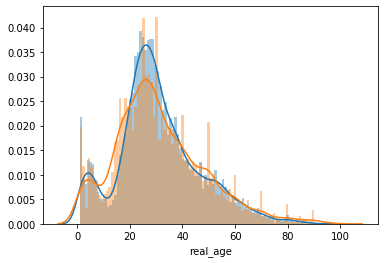

In [19]:
# Lets see the distribution of the apparent age and the real age
sns.distplot(df_all["apparent_age_avg"], bins=100)
sns.distplot(df_all["real_age"], bins=100)

The Distribution of age dont deviate too much between the real and the apparent, we can keep it

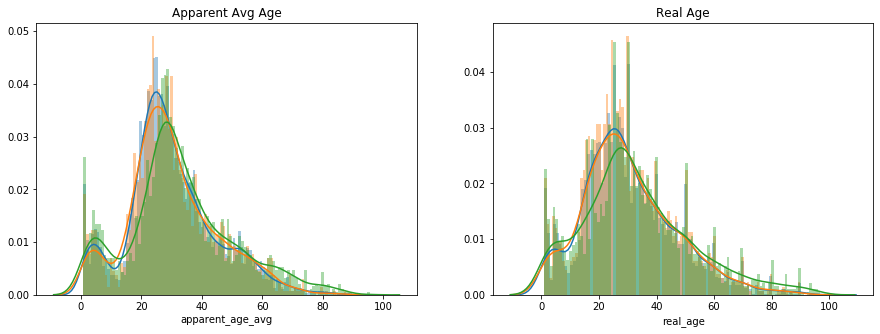

In [29]:
# Now we will check the dist between the train, eval and test datasets
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1, title="Apparent Avg Age")
sns.distplot(df_train["apparent_age_avg"], bins=100)
sns.distplot(df_eval["apparent_age_avg"], bins=100)
sns.distplot(df_test["apparent_age_avg"], bins=100)

plt.subplot(1, 2, 2, title="Real Age")
sns.distplot(df_train["real_age"], bins=100)
sns.distplot(df_eval["real_age"], bins=100)
sns.distplot(df_test["real_age"], bins=100)

plt.show()

This one can be better, dist of test set deviates a bit from train set, but we can keep with this for now. But this visualizations open some questions, how much the avg age deviates from the real age? putting a response here can lead us to detect some possible outliers, because the avg is based on manual reviews from real people that stimates the age of the person they see in the photo. Lets check that

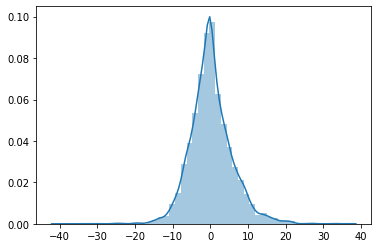

In [32]:
diference = df_all["real_age"] - df_all["apparent_age_avg"]
sns.distplot(diference, bins=50)

## Preprocessing

In [0]:
#Find urls
root = "./Datasets"
folders = os.listdir(root)
urls = list()

if(not ("dataset.csv" in folders)):

  folders.remove("imdb.tar.gz")
  folders.remove("wiki.tar.gz")

  for folder in folders:
    subfolders = os.listdir("{root}/{folder}".format(root=root, folder=folder))
    for subfolder in subfolders:
      files = os.listdir("{root}/{folder}/{subfolder}".format(root=root, folder=folder, subfolder=subfolder))
      for file in files:
        path = "{root}/{folder}/{subfolder}/{file}".format(root=root, folder=folder, subfolder=subfolder, file=file)
        urls.append(path)

In [0]:
#Load csv
faces_df = pd.read_csv("./Datasets/dataset.csv")

#Shuffle
faces_df = faces_df.sample(frac=1.0)
faces_df.head()

,id,age,born,taken,url
423648,i0000848,23,1965,1988,./Datasets/imdb_crop/48/nm0000848_rm3978006016...
71373,i1406730,40,1974,2014,./Datasets/imdb_crop/30/nm1406730_rm1062062848...
12458,i454846,0,2014,2014,./Datasets/wiki_crop/46/31454846_1948-10-03_20...
303742,i0002075,55,1916,1971,./Datasets/imdb_crop/75/nm0002075_rm2321726208...
80455,i0179173,43,1961,2004,./Datasets/imdb_crop/73/nm0179173_rm2795944448...


In [0]:
faces_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523051 entries, 423648 to 200861
Data columns (total 5 columns):
id       523051 non-null object
age      523051 non-null int64
born     523051 non-null int64
taken    523051 non-null int64
url      523051 non-null object
dtypes: int64(3), object(2)
memory usage: 23.9+ MB


In [0]:
#Double check for null datapoints
faces_df.isnull().sum()

id       0
age      0
born     0
taken    0
url      0
dtype: int64

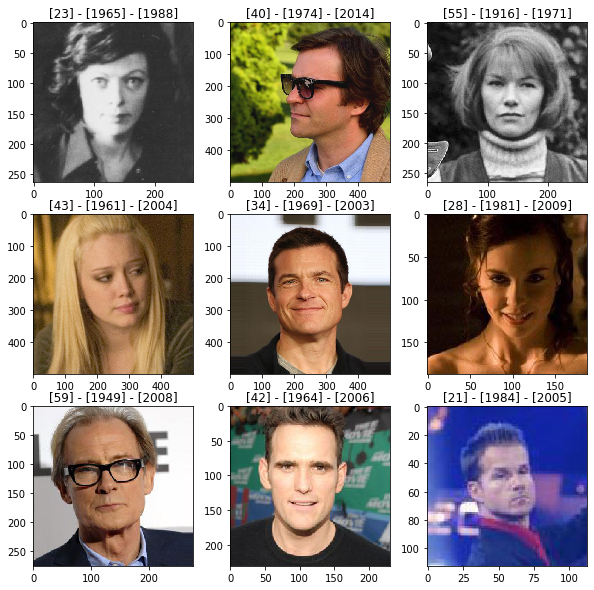

In [0]:
#Lets see some examples
plt.figure(figsize=(10,10))
for i, path in enumerate(faces_df["url"].iloc[:9]):
    img = tf.keras.preprocessing.image.load_img(path)

    datapoint = faces_df[faces_df["url"] == path]
    age = datapoint["age"].values
    born = datapoint["born"].values
    taken = datapoint["taken"].values

    plt.subplot(3,3,i+1, title="{age} - {born} - {taken}".format(age=age, born=born, taken=taken))
    plt.imshow(img)
plt.show()

In [0]:
#Check descriptive statistics
faces_df.describe()

,age,born,taken
count,523051.000000,523051.000000,523051.000000
mean,32.978163,1971.685490,2004.663652
std,35.476414,36.214104,11.358271
min,-30.000000,0.000000,1940.000000
25%,24.000000,1962.000000,2003.000000
50%,33.000000,1972.000000,2008.000000
75%,43.000000,1982.000000,2011.000000
max,2015.000000,2015.000000,2015.000000


High Precense of outliers, lets fix that

In [0]:
#Clear Dataset from outliers
age_up_0 = faces_df["age"] > 5
age_down_75 = faces_df["age"] < 75
faces_df = faces_df[age_up_0 & age_down_75]
faces_df.describe()

,age,born,taken
count,454876.000000,454876.000000,454876.000000
mean,36.542420,1968.946385,2005.488806
std,12.389768,14.730325,8.983963
min,6.000000,1890.000000,1961.000000
25%,28.000000,1961.000000,2004.000000
50%,35.000000,1971.000000,2008.000000
75%,44.000000,1979.000000,2011.000000
max,74.000000,2008.000000,2015.000000


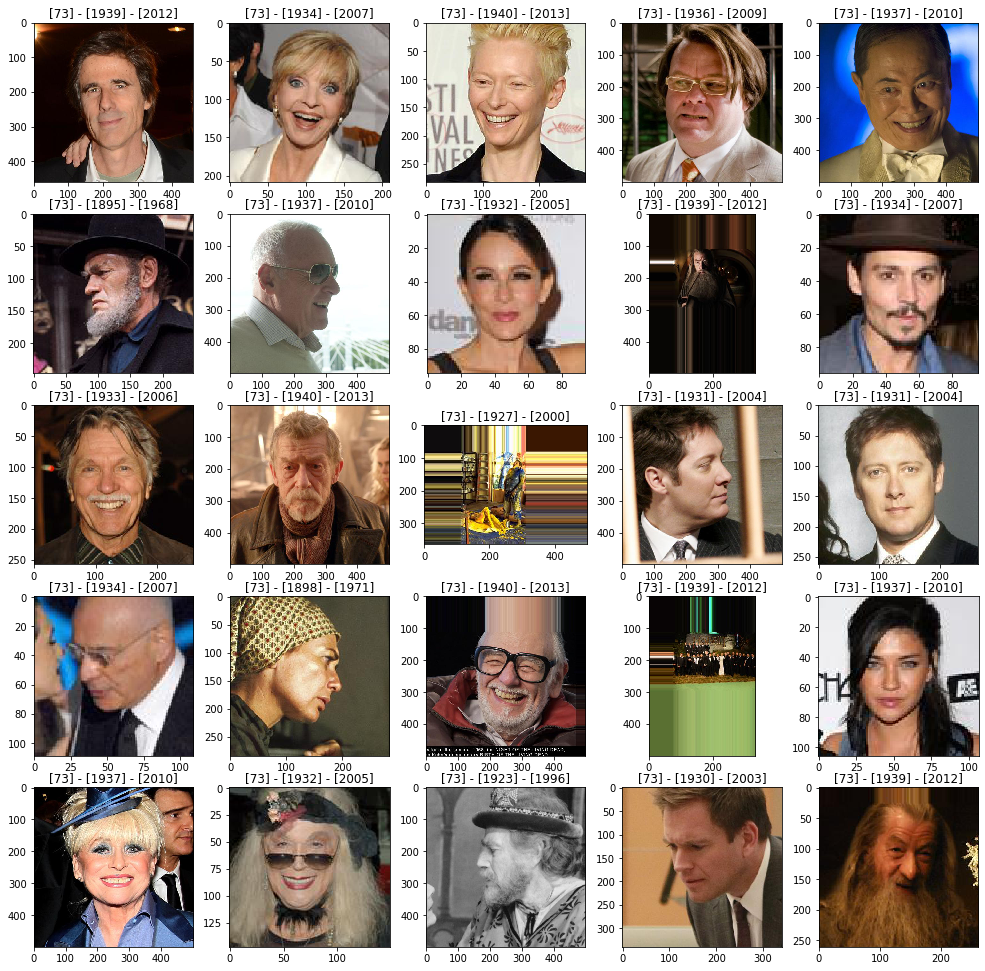

In [0]:
#Lets see some 1 year examples
babies = faces_df[faces_df["age"] == 73]

plt.figure(figsize=(17, 17))
for i, path in enumerate(babies["url"].iloc[:25]):
    img = tf.keras.preprocessing.image.load_img(path)

    datapoint = faces_df[faces_df["url"] == path]
    age = datapoint["age"].values
    born = datapoint["born"].values
    taken = datapoint["taken"].values

    plt.subplot(5,5,i+1, title="{age} - {born} - {taken}".format(age=age, born=born, taken=taken))
    plt.imshow(img)
plt.show()

In [0]:
#Check for how much unique people is here
id_count = faces_df["id"].nunique()
"The Dataset contains {count} unique persons across its images".format(count=id_count)

'The Dataset contains 19956 unique persons across its images'

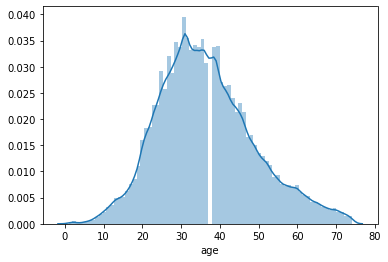

In [0]:
#Lets see the distribution of the age across our dataset
sns.distplot(faces_df["age"], bins=75)

## Dataset Preparation

In [0]:
#Split dataset between train, eval and test
full_df = faces_df
eval_df = full_df.sample(frac=0.05)
full_df = full_df.drop(eval_df.index)
test_df = full_df.sample(frac=0.05)
train_df = full_df.drop(test_df.index)

In [0]:
#Store number of datapoints in each dataset
train_count = train_df.shape[0]
eval_count = eval_df.shape[0]
test_count = test_df.shape[0]
print("Train samples: " + str(train_count))
print("Evaluation samples: " + str(eval_count))
print("Test samples: " + str(test_count))

In [0]:
#Verify the distribution of the three splits
sns.distplot(a=train_df["age"], bins=75).set_title("Users Distribution")
sns.distplot(a=eval_df["age"], bins=75)
sns.distplot(a=test_df["age"], bins=75)

plt.show()

## Dataset Creation

In [0]:
#Generator funcion
tf.train.

In [0]:
#Create Datasets for train, evaluation and testing
train_ds = tf.data.Dataset.from_tensor_slices().shuffle(4196)
eval_ds = tf.data.Dataset.from_tensor_slices().batch(eval_count)
test_ds = tf.data.Dataset.from_tensor_slices().batch(test_count)